In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Load your dataset
df = pd.read_csv('spotify_churn_dataset.csv') # Replace with your actual file name

# Drop user_id as it's just an identifier, not a predictor for churn
df_ml = df.drop(columns=['user_id'])

# Preview the data to ensure it loaded correctly
print(df_ml.head())

  subscription_type country  avg_daily_minutes  number_of_playlists  \
0           Premium      US              134.9                    4   
1           Premium      PK              165.7                    5   
2              Free      DE               45.9                    3   
3           Premium      PK              106.0                    0   
4           Premium      US               89.6                    5   

    top_genre  skips_per_day  support_tickets  days_since_last_login  churned  
0  Electronic              6                0                      1        0  
1         Pop              8                0                     12        0  
2   Classical              3                0                      3        0  
3        Jazz              7                0                      3        0  
4     Country              2                1                      6        0  


In [7]:
# Identify Numerical and Categorical columns based on your dashboard
num_features = ['avg_daily_minutes', 'skips_per_day', 'number_of_playlists', 
                'support_tickets', 'days_since_last_login']

cat_features = ['subscription_type', 'country', 'top_genre']

# Target variable is already binary (0 or 1) per your dataset
X = df_ml.drop('churned', axis=1)
y = df_ml['churned']


0      0
1      0
2      0
3      0
4      0
      ..
995    1
996    0
997    0
998    1
999    0
Name: churned, Length: 1000, dtype: int64


In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])


X_processed = preprocessor.fit_transform(X)


encoded_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)
all_cols = num_features + list(encoded_cols)

df_processed = pd.DataFrame(X_processed, columns=all_cols)

print("Preprocessed Data Shape:", df_processed.shape)
df_processed.head()

Preprocessed Data Shape: (1000, 24)


,avg_daily_minutes,skips_per_day,number_of_playlists,support_tickets,days_since_last_login,subscription_type_Free,subscription_type_Premium,country_AU,country_BR,country_CA,...,country_RU,country_UK,country_US,top_genre_Classical,top_genre_Country,top_genre_Electronic,top_genre_Hip-Hop,top_genre_Jazz,top_genre_Pop,top_genre_Rock
0,0.873244,0.493198,0.243666,-0.451379,-0.872535,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.591274,1.213722,0.674171,-0.451379,0.257160,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.201584,-0.587587,-0.186839,-0.451379,-0.667136,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.199508,0.853460,-1.478355,-0.451379,-0.667136,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.182820,-0.947849,0.674171,1.494220,-0.359037,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [9]:
from sklearn.model_selection import train_test_split

# We use 80% of the data for training and 20% for testing
# random_state ensures you get the same results every time you run the cell
X_train, X_test, y_train, y_test = train_test_split(
    df_processed, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 800 samples
Testing set size: 200 samples


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize the model
# n_estimators=100 means we are using 100 "trees" to make the decision
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Check the results
print("--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

--- Confusion Matrix ---
[[159   4]
 [ 30   7]]

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       163
           1       0.64      0.19      0.29        37

    accuracy                           0.83       200
   macro avg       0.74      0.58      0.60       200
weighted avg       0.80      0.83      0.79       200



In [12]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the model
# 'balanced' helps with the fact that you have fewer churners than active users
log_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
log_model.fit(X_train, y_train)

# Make predictions
y_pred_log = log_model.predict(X_test)

print("--- Logistic Regression Results ---")
print(confusion_matrix(y_test, y_pred_log))
print("\n", classification_report(y_test, y_pred_log))

--- Logistic Regression Results ---
[[111  52]
 [ 18  19]]

               precision    recall  f1-score   support

           0       0.86      0.68      0.76       163
           1       0.27      0.51      0.35        37

    accuracy                           0.65       200
   macro avg       0.56      0.60      0.56       200
weighted avg       0.75      0.65      0.68       200



In [13]:
import numpy as np

# Get the coefficients
importance = log_model.coef_[0]
feature_names = df_processed.columns

# Combine them into a readable format
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': importance})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

print("Top Drivers of Churn (Positive = Increases Churn Risk):")
print(feature_importance.head(5))

print("\nTop Drivers of Loyalty (Negative = Decreases Churn Risk):")
print(feature_importance.tail(5))

Top Drivers of Churn (Positive = Increases Churn Risk):
                   Feature  Coefficient
5   subscription_type_Free     0.758885
3          support_tickets     0.686116
4    days_since_last_login     0.593974
16              country_US     0.500504
7               country_AU     0.370154

Top Drivers of Loyalty (Negative = Decreases Churn Risk):
                      Feature  Coefficient
0           avg_daily_minutes    -0.502422
23             top_genre_Rock    -0.548303
15                 country_UK    -0.599189
12                 country_IN    -0.617086
6   subscription_type_Premium    -0.944582


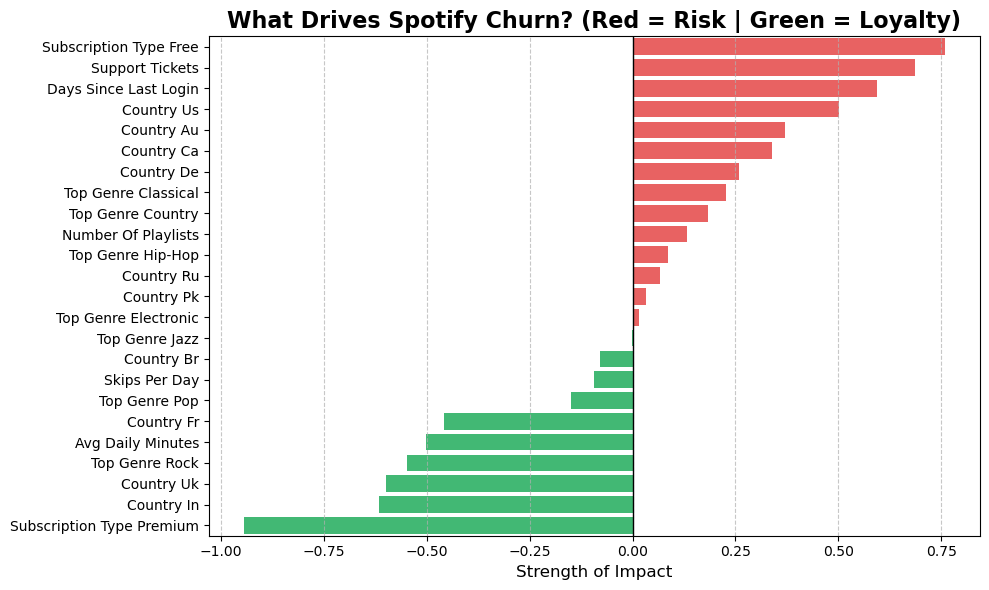

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Clean up names for a layman
feature_importance['Feature'] = feature_importance['Feature'].str.replace('_', ' ').str.title()

# 2. Create the plot
plt.figure(figsize=(10, 6))

# Assign 'Feature' to hue to satisfy the new Seaborn requirement
# legend=False prevents a messy legend from appearing on the side
sns.barplot(
    x='Coefficient', 
    y='Feature', 
    data=feature_importance, 
    hue='Feature', 
    palette=colors, 
    legend=False
)

plt.title('What Drives Spotify Churn? (Red = Risk | Green = Loyalty)', fontsize=16, fontweight='bold')
plt.xlabel('Strength of Impact', fontsize=12)
plt.ylabel('', fontsize=12)
plt.axvline(x=0, color='black', linestyle='-', linewidth=1) 
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

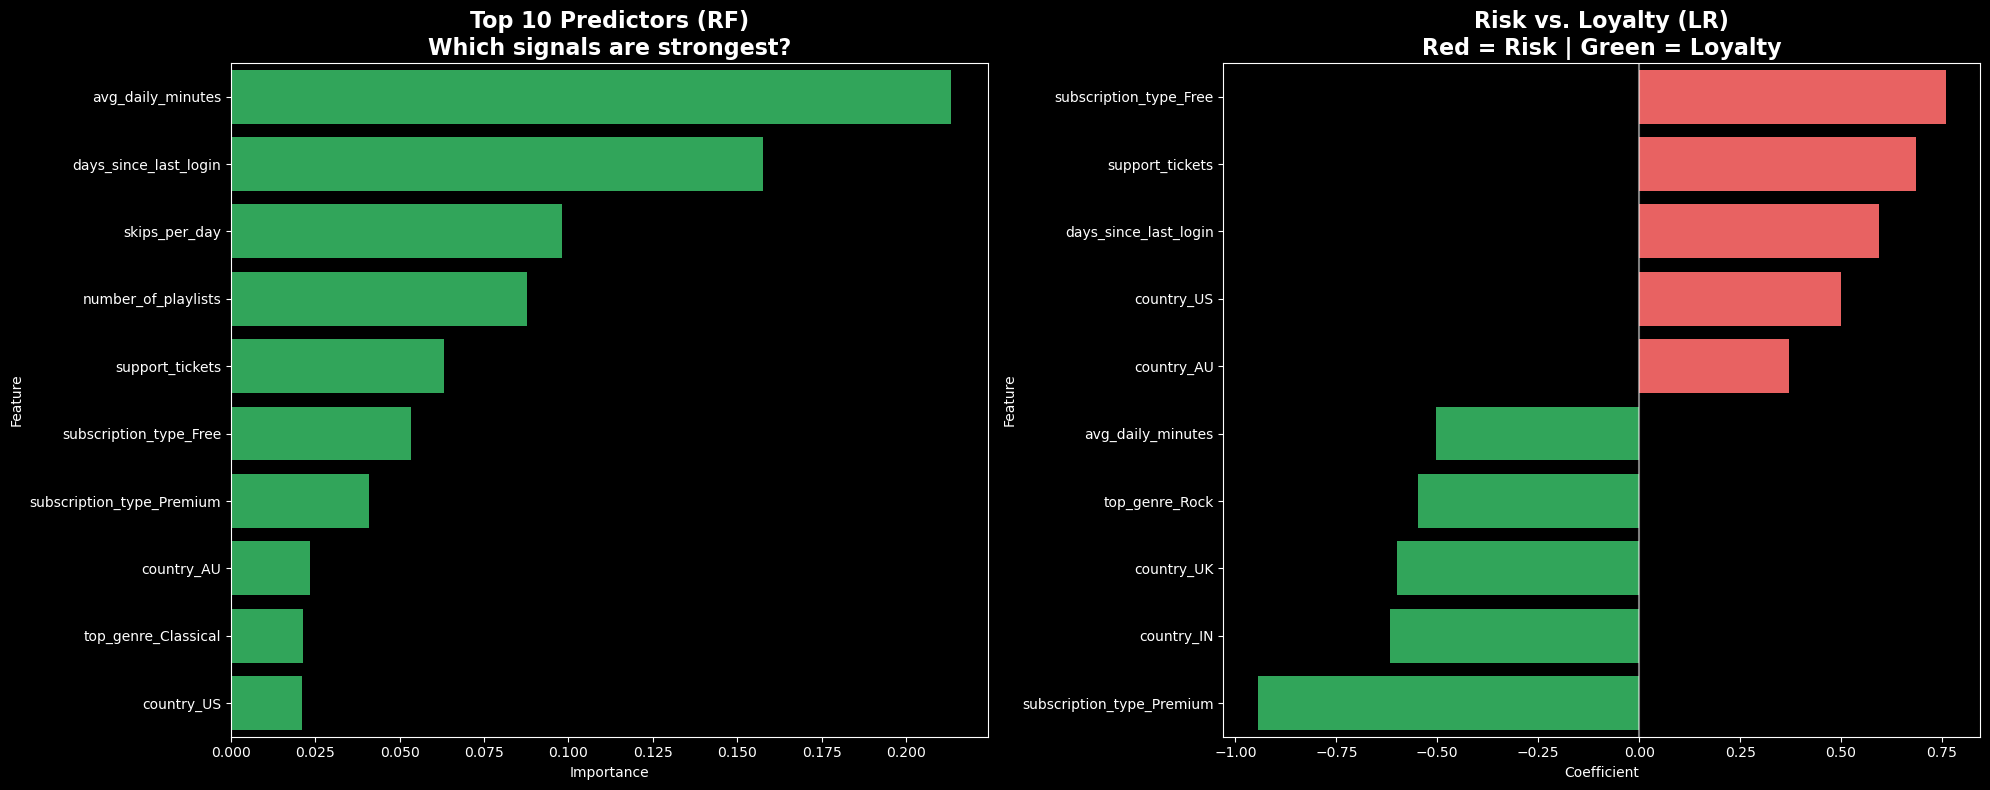

In [17]:
# 1. Prepare the Top/Bottom drivers for the Logistic Regression plot
top_bottom_log = pd.concat([log_coeff.head(5), log_coeff.tail(5)])

# 2. Generate a NEW color list specifically for these 10 items
# This fixes the "UserWarning" about having too many colors
colors_log = ['#ff4b4b' if x > 0 else '#1DB954' for x in top_bottom_log['Coefficient']]

# --- Start Plotting ---
plt.style.use('dark_background')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot A: Random Forest (The "Predictors") - Top 10
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=rf_importance.head(10), 
    color='#1DB954', 
    ax=ax1
)
ax1.set_title('Top 10 Predictors (RF)\nWhich signals are strongest?', fontsize=16, fontweight='bold')

# Plot B: Logistic Regression (The "Drivers") - Top 5 and Bottom 5
# hue='Feature' and legend=False fix the "FutureWarning"
sns.barplot(
    x='Coefficient', 
    y='Feature', 
    data=top_bottom_log, 
    hue='Feature', 
    palette=colors_log, 
    legend=False, 
    ax=ax2
)
ax2.set_title('Risk vs. Loyalty (LR)\nRed = Risk | Green = Loyalty', fontsize=16, fontweight='bold')
ax2.axvline(x=0, color='white', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()